In [1]:
import numpy as np
import pandas as pd

import os
import glob
import librosa
import tqdm
import pickle
import time

from collections import Counter, defaultdict

from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim import lr_scheduler
from torch import nn
import torch.nn.functional as F
import torch

from skmultilearn.model_selection import iterative_train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import utils
from flame import Trainer

sns.set()

DATA_PATH = './data'
join_path = lambda path: os.path.join(DATA_PATH, path)

In [2]:
with open(join_path('train_mels.pkl'), 'rb+') as f:
    train_X = pickle.load(f)
    
with open(join_path('val_mels.pkl'), 'rb+') as f:
    val_X = pickle.load(f)
    
train_y = np.load(join_path('train_targets.npy'))
val_y = np.load(join_path('val_targets.npy'))

In [3]:
train_ds = utils.create_ds(train_X, train_y)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

val_ds = utils.create_ds(val_X, val_y)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)

In [4]:
# Deep Convolutional Neural Network for Environmental Sound Classification
# https://arxiv.org/pdf/1608.04363v2.pdf

class DCNN(nn.Module):
    def __init__(self, hid=256):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=24, kernel_size=5),
            nn.MaxPool2d(kernel_size=(4, 2), stride=(4, 2)),
            nn.ReLU(),
            nn.Conv2d(in_channels=24, out_channels=48, kernel_size=5),
            nn.MaxPool2d(kernel_size=(4, 2), stride=(4, 2)),
            nn.ReLU(),
            nn.Conv2d(in_channels=48, out_channels=48,kernel_size=5),
            nn.ReLU()
        )
        
        self.clf = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=2400, out_features=hid),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=hid, out_features=80)
        )
        
        
    def forward(self, x):
        x = self.convs(x)
        x = x.flatten(start_dim=1)
        x = self.clf(x)
        return x

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss()

model = DCNN(hid=256)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
logdir = join_path('DCNN_logdir')

trainer = Trainer(model, optimizer, criterion, device, logdir)

scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode='max',
    factor=0.5,
    patience=10,
    verbose=True
)

In [6]:
losses, best_loss, epoch_time = utils.train_model(trainer, train_dl, val_dl, val_y, scheduler,
                                            n_epochs=1000, gap=20, verbose=True)

Epoch, best_val_lwlrap
   1, 0.0940
   2, 0.1527
   3, 0.1881
   4, 0.2457
   5, 0.2947
   6, 0.3330
   7, 0.3693
   8, 0.3860
   9, 0.4117
  11, 0.4500
  13, 0.4672
  14, 0.5050
  16, 0.5120
  17, 0.5192
  20, 0.5461
  21, 0.5670
  23, 0.5696
  27, 0.5745
  28, 0.5852
  35, 0.5917
  37, 0.6023
  45, 0.6044
  48, 0.6077
  52, 0.6156
  62, 0.6231
Epoch    73: reducing learning rate of group 0 to 5.0000e-04.
  82, 0.6241
Epoch    93: reducing learning rate of group 0 to 2.5000e-04.
 102, 0.6265
 113, 0.6295
Epoch   124: reducing learning rate of group 0 to 1.2500e-04.
Done.


In [10]:
epoch_time, best_loss

(0.9900907663474405, 0.6295172510050132)

Text(0.5, 1.0, 'Logloss')

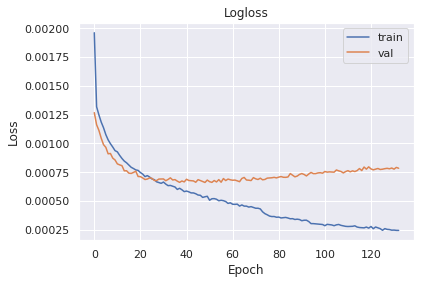

In [11]:
plt.plot(losses['train']['logloss'])
plt.plot(losses['val']['logloss'])
plt.legend(['train', 'val'])

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Logloss')

Text(0.5, 1.0, 'Lwlrap')

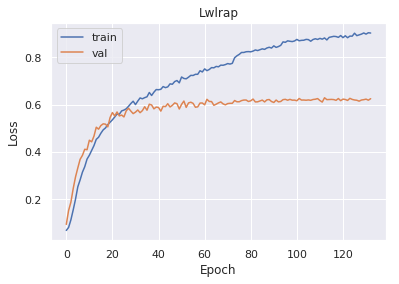

In [12]:
plt.plot(losses['train']['lwlrap'])
plt.plot(losses['val']['lwlrap'])
plt.legend(['train', 'val'])

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Lwlrap')

In [17]:
with open(join_path('DCNN_losses.pkl'), 'wb+') as f:
    pickle.dump(losses, f)